### 目的
* Kallus et al., 2018のOPEの実験を再現すること

### Task
- [ ] 人工的な観測データを生成する。
- [ ] 論文で指定してあるbehavior policy, target policyを実装する。
- [ ] estimatorを実装して評価する。
- [ ] Open Bandit Pipelineで比較する既存手法を実装して評価する。
- [ ] Continuous OPEと既存手法の結果を視覚的に比較する。Fig(matplotlib), Table(pandas)を作成する。

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy import stats, integrate

In [2]:
# Section5.1のOPE用データ生成
# (x, t, y)
def gen(n, seed=0):
    '''
    n: データ数
    '''
    # NOTE: 縦ベクトルで返す
    np.random.seed(seed)
    x = np.random.uniform(low=0, high=1, size=(n, 1))
    t = x + 0.1 + 0.5 * np.random.randn(n, 1)
    epsilon = np.random.randn(n, 1)
    y = 2 * np.power(np.abs(x - t), 1.5) + 0.2 * epsilon
    return (x, t, y)

In [3]:
# \pi(x) = \beta * x
def target_policy(x):
    beta = 1
    return beta * x

def behavior_policy(t, x):
    # T|X ~ N(x + 0.1, 0.5)
    return stats.norm.pdf(t, loc=x + 0.1, scale=0.5)

### Epanechnikov kernelの$\kappa_2(K)$および$R(K)$

* この論文ではEpanechnikov kernelは$K(u) = \frac{3}{4} (1 - u^2) \mathbb{I}\{\|u \| \le 1\}$となっている。

* なので、second moment$\kappa_2(K) = \int u^2 K(u) du$は、$\int u^2 K(u) du = \left[\frac{3}{4}(x^5/5 - 2x^3/3 + x\right]_{-1}^{1} = \frac{3}{4}\frac{16}{15} = \frac{4}{5}$

* さらに、roughness$R(K) = \int K(u)^2du$は、$\int K(u)^2 du = \frac{9}{16} \left[ x^3/3 - x^5/5 \right]_{-1}^1 = \frac{9}{16} \frac{4}{15} = \frac{3}{20}$

* よって、実験のoptimal bandwidthの算出にはこの数値を利用する。
* 計算には、[このツール](https://ja.wolframalpha.com/input/?i=%E7%A9%8D%E5%88%86%E8%A8%88%E7%AE%97)を利用した。

### Optimal Bandwidth
* section3.2のTheorem2を利用する。

$
h^{*} = \left(
    \frac{
        R(K) \mathbb{E}\left[\mathbb{E}[Y^2|\tau(X), X]/f_{T|X}(\tau(X), X)\right]
    }{
        4 \left(
            \mathbb{E} \left[ \int \frac{y_i}{2} \frac{\partial}{\partial T^2} f_{Y|T, x}(y_i, \tau(x_i)) \kappa_2(K) dy \right]
        \right)^2 n
    }
\right)^{\frac{1}{5}}
$

* section5.1によれば、2次の微分係数や積分は数値微分, 数値積分を用いる。ここでは、numpy.gradient(y, dx), scipy.integrate.simps(y, x)を利用する。
    * [scipy.integrate.simps](https://qiita.com/sci_Haru/items/09279cf81b9b073afa1d)

* $E[Y^2|\pi(x), X]$は生成したデータのうち、$T = \pi(X)$が成り立つサンプルの2

* $f_{Y|T, x}(y_i, \pi(x_i))$, $f_{T|X}(\pi(X), X)$が謎？

In [21]:
# epanechnikov kernelの2次モーメントとRoughness
R_K = 3/20
KAPPA2_K = 4/5

In [5]:
# n = 10の場合のoptimal bandwidthを求める。
n = 10
X, T, Y = gen(n)
piX = target_policy(X)  # ターゲット方策を用いた場合の介入\pi(X)

In [6]:
# E[Y|\pi(X), X]を近似 50回のreplicationで期待値を禁じ
df = pd.DataFrame(np.hstack([X, T, Y, piX]), columns=['X', 'T', 'Y', 'piX'])
E_Y2 = df.groupby(['X', 'piX'])['Y'].apply(lambda x: (x**2).sum()).to_numpy()

f_T_on_X = behavior_policy(piX, X)

numerator = R_K * np.mean(E_Y2 / f_T_on_X)

In [7]:
# f_{Y|T, X}を求める。
# 分子 pdf
YTX = np.hstack([Y, T, X])
joint_density_YTX = KernelDensity(kernel='epanechnikov', bandwidth=1).fit(YTX)
# 分母 pdf
TX = np.hstack([T, X])
density_TX = KernelDensity(kernel='epanechnikov', bandwidth=1).fit(TX)

# Y|T, X pdf
YpiXX = np.hstack([Y, piX, X])
piXX = np.hstack([piX, X])
conditional_density_Y_on_piXX = joint_density_YTX.score_samples(YpiXX) / density_TX.score_samples(piXX)

# 数値微分
dt = 1e-7 # 適当
partial_f_partial_T = np.gradient(conditional_density_Y_on_piXX, dt)
partial_f_partial_T2 = np.gradient(partial_f_partial_T, dt)

# 数値積分
integral_y = integrate.simps(Y[:, 0] * partial_f_partial_T2 * KAPPA2_K / 2, Y[:, 0])

denominator = 4 * integral_y**2 * n

In [8]:
n0_optimal_bandwidth = np.power(numerator / denominator, 1/5)
n0_optimal_bandwidth

4.685401611715447e-05

In [15]:
R = 50

def kernel_epanechnikov(u):
    return np.where(np.abs(u) <= 1, 3 * (1 - u**2) / 4, 0)

results_list = []
n_samples = range(10, 310, 10)
for n in n_samples:
    v_hat_list = []
    for seed in range(R):
        X, T, Y = gen(n, seed=seed)
        piX = target_policy(X)
    
        h = n0_optimal_bandwidth * np.power(10/n, 1/5)

        Q = behavior_policy(T, X)
    
        v_hat = np.mean(kernel_epanechnikov((piX - T) / h) * Y / Q) / h
        v_hat_list.append(v_hat)
    v_hat_array = np.array(v_hat_list)
    v_mean = v_hat_array.mean()
    v_std = v_hat_array.std()
    results_list.append([v_mean, v_std])
results_array = np.array(results_list)

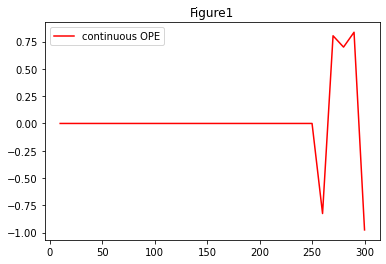

In [20]:
plt.title('Figure1')
# TODO: matplotlibでのcolorの表示の仕方
plt.plot(n_samples, results_array[:, 0], color='red', label='continuous OPE')
plt.legend()
plt.show()